# Intro to Stats Learning

## Lab 4

### Lab 4 - Logistic Regression, LDA, QDA, KNN

> https://juliaai.github.io/DataScienceTutorials.jl/isl/lab-4/
> <br> (project folder) https://raw.githubusercontent.com/juliaai/DataScienceTutorials.jl/gh-pages/__generated/ISL-lab-4.tar.gz

In [1]:
using Pkg; Pkg.activate("D:/JULIA/6_ML_with_Julia/ISL-lab-4"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\ISL-lab-4`


> Stock market data
> 1. Logistic Regression
> 2. LDA
> 3. QDA
> 4. KNN
> Caravan insurance data
> 1. ROC and AUC

### Stock market data

---

Let's load the usual packages and the data
```R
S&P Stock Market Data
Description
Daily percentage returns for the S&P 500 stock index between 2001 and 2005.

Usage
Smarket
Format
A data frame with 1250 observations on the following 9 variables.

Year
The year that the observation was recorded

Lag1
Percentage return for previous day

Lag2
Percentage return for 2 days previous

Lag3
Percentage return for 3 days previous

Lag4
Percentage return for 4 days previous

Lag5
Percentage return for 5 days previous

Volume
Volume of shares traded (number of daily shares traded in billions)

Today
Percentage return for today

Direction
A factor with levels Down and Up indicating whether the market had a positive or negative return on a given day
```

In [2]:
using MLJ
import RDatasets: dataset
import DataFrames: DataFrame, describe, select, Not
import StatsBase: countmap, cor, var
using PrettyPrinting

smarket = dataset("ISLR", "Smarket")
@show size(smarket)
@show names(smarket)

size(smarket) = (1250, 9)
names(smarket) = ["Year", "Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume", "Today", "Direction"]


9-element Vector{String}:
 "Year"
 "Lag1"
 "Lag2"
 "Lag3"
 "Lag4"
 "Lag5"
 "Volume"
 "Today"
 "Direction"

Since we often want to only show a few significant digits for the metrics etc, let's introduce a very simple function that does that:

In [3]:
r3(x) = round(x, sigdigits = 3)
r3(pi)

3.14

Let's get a description too

In [4]:
describe(smarket, :mean, :std, :eltype)

,variable,mean,std,eltype
,Symbol,Union…,Union…,DataType
1,Year,2003.02,1.40902,Float64
2,Lag1,0.0038344,1.1363,Float64
3,Lag2,0.0039192,1.13628,Float64
4,Lag3,0.001716,1.1387,Float64
5,Lag4,0.001636,1.13877,Float64
6,Lag5,0.0056096,1.14755,Float64
7,Volume,1.4783,0.360357,Float64
8,Today,0.0031384,1.13633,Float64
9,Direction,,,"CategoricalValue{String, UInt8}"


The target variable is ```:Direction```:

In [5]:
y = smarket.Direction
X = select(smarket, Not(:Direction));

We can compute all the pairwise correlations; we use ```Matrix``` so that the dataframe entries are considered as one matrix of numbers with the same type (otherwise ```cor``` won't work):

In [6]:
cm = X |> Matrix |> cor

8×8 Matrix{Float64}:
 1.0         0.0296996    0.0305964    0.0331946   …   0.539006    0.0300952
 0.0296996   1.0         -0.0262943   -0.0108034       0.0409099  -0.026155
 0.0305964  -0.0262943    1.0         -0.0258967      -0.0433832  -0.01025
 0.0331946  -0.0108034   -0.0258967    1.0            -0.0418237  -0.00244765
 0.0356887  -0.00298591  -0.0108535   -0.024051       -0.0484142  -0.00689953
 0.029788   -0.00567461  -0.00355795  -0.0188083   …  -0.0220023  -0.0348601
 0.539006    0.0409099   -0.0433832   -0.0418237       1.0         0.0145918
 0.0300952  -0.026155    -0.01025     -0.00244765      0.0145918   1.0

In [7]:
round.(cm, sigdigits = 1)

8×8 Matrix{Float64}:
 1.0    0.03    0.03    0.03    0.04    0.03    0.5    0.03
 0.03   1.0    -0.03   -0.01   -0.003  -0.006   0.04  -0.03
 0.03  -0.03    1.0    -0.03   -0.01   -0.004  -0.04  -0.01
 0.03  -0.01   -0.03    1.0    -0.02   -0.02   -0.04  -0.002
 0.04  -0.003  -0.01   -0.02    1.0    -0.03   -0.05  -0.007
 0.03  -0.006  -0.004  -0.02   -0.03    1.0    -0.02  -0.03
 0.5    0.04   -0.04   -0.04   -0.05   -0.02    1.0    0.01
 0.03  -0.03   -0.01   -0.002  -0.007  -0.03    0.01   1.0

Let's see what the ```:volume``` feature looks like:

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


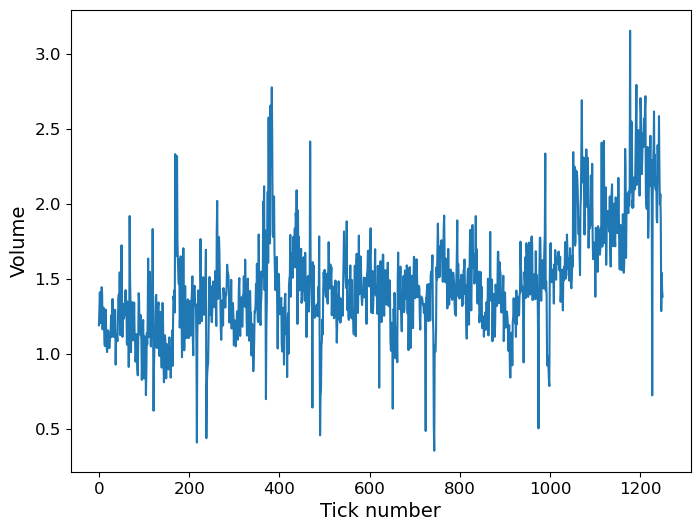

In [8]:
using PyPlot
figure(figsize=(8,6))
plot(X.Volume)
xlabel("Tick number", fontsize = 14)
ylabel("Volume", fontsize = 14)
xticks(fontsize=12)
yticks(fontsize=12)
savefig("./plots/3.3.1.png")

### Logistic Regression

We will now try to train models; the target ```:Direction``` has two classes: ```Up``` and ```Down```; it needs to be interpreted as a categorical object, and we will mark it as a ordered factor to specify that 'Up' is positive and 'Down' negative (for the confusion matrix later):

In [9]:
y = coerce(y, OrderedFactor)
classes(y[1])

2-element CategoricalArrays.CategoricalArray{String,1,UInt8}:
 "Down"
 "Up"

Note that in this case the default order comes from the lexicographic order which happens to map to our intuition since ```D``` comes before ```U```.

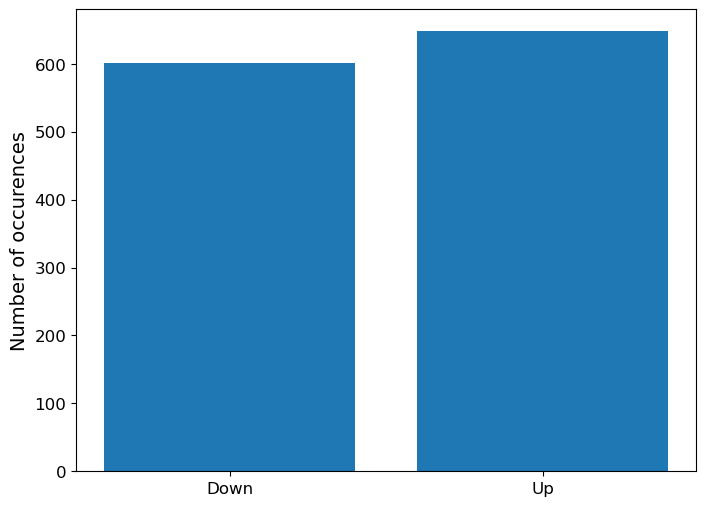

In [10]:
figure(figsize = (8,6))
cm = countmap(y)
PyPlot.bar([1, 2], [cm["Down"], cm["Up"]])
xticks([1, 2], ["Down", "Up"], fontsize = 12)
yticks(fontsize = 12)
ylabel("Number of occurences", fontsize = 14)
savefig("./plots/3.3.2.png")

Seems pretty balanced.

Let's now try fitting a simple logistic classifier (aka logistic regression) not using ```:Year``` and ```:Today```:

In [11]:
LogisticClassifier = @load LogisticClassifier pkg = MLJLinearModels
X2 = select(X, Not([:Year, :Today]))
classif = machine(LogisticClassifier(), X2, y)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


import MLJLinearModels ✔


Machine{LogisticClassifier,…} trained 0 times; caches data
  model: MLJLinearModels.LogisticClassifier
  args: 
    1:	Source @649 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @895 ⏎ `AbstractVector{OrderedFactor{2}}`


Let's fit it to the data and try to reproduce the output:

In [12]:
fit!(classif)
ŷ = MLJ.predict(classif, X2)
ŷ[1:3]

┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


3-element CategoricalDistributions.UnivariateFiniteArray{OrderedFactor{2}, String, UInt8, Float64, 1}:
 UnivariateFinite{OrderedFactor{2}}(Down=>0.482, Up=>0.518)
 UnivariateFinite{OrderedFactor{2}}(Down=>0.489, Up=>0.511)
 UnivariateFinite{OrderedFactor{2}}(Down=>0.49, Up=>0.51)

Note that here the ŷ are scores. We can recover the average cross-entropy loss:

In [13]:
cross_entropy(ŷ, y) |> mean |> r3

0.692

in order to recover the class, we could use the mode and compare the misclassification rate:

In [14]:
ŷ = predict_mode(classif, X2)
misclassification_rate(ŷ, y) |> r3

0.482

Well that's not fantastic...

Let's visualise how we're doing building a confusion matrix, first is predicted, second is truth:

In [15]:
cm = confusion_matrix(ŷ, y)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    Down     │     Up      │
├─────────────┼─────────────┼─────────────┤
│    Down     │      4      │      5      │
├─────────────┼─────────────┼─────────────┤
│     Up      │     598     │     643     │
└─────────────┴─────────────┴─────────────┘


We can then compute the accuracy or precision, etc. easily for instance:

In [16]:
@show false_positive(cm)
@show accuracy(ŷ, y) |> r3
@show accuracy(cm) |> r3 # same thing

false_positive(cm) = 598
accuracy(ŷ, y) |> r3 = 0.518
accuracy(cm) |> r3 = 0.518


0.518

In [17]:
@show precision(ŷ, y) |> r3
@show recall(ŷ, y) |> r3
@show f1score(ŷ, y) |> r3

precision(ŷ, y) |> r3 = 0.518
recall(ŷ, y) |> r3 = 0.992
f1score(ŷ, y) |> r3 = 0.681


0.681

Let's now train on the data before 2005 and use it to predict on the rest. Let's find the row indices for which the condition holds

In [18]:
train = 1:findlast(X.Year .< 2005)
test = last(train) + 1:length(y);

We can now just re-fit the machine that we've already defined just on those rows and predict on the test:

In [19]:
fit!(classif, rows = train)
ŷ = predict_mode(classif, rows = test)
accuracy(ŷ, y[test]) |> r3

┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


0.563

Well, that's not very good... Let's retrain a machine using only ```:Lag1``` and ```:Lag2```:

In [20]:
X3 = select(X2, [:Lag1, :Lag2])
classif = machine(LogisticClassifier(), X3, y)
fit!(classif, rows = train)
ŷ = predict_mode(classif, rows = test)
accuracy(ŷ, y[test]) |> r3

┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


0.56

Interesting... it has higher accuracy than the model with more features! This could be investigated further by increasing the regularisation parameter but we'll leave that aside for now.

We can use a trained machine to predict on new data:

In [21]:
Xnew = (Lag1 = [1.2, 1.5], Lag2 = [1.1, -0.8])

(Lag1 = [1.2, 1.5],
 Lag2 = [1.1, -0.8],)

In [22]:
ŷ = MLJ.predict(classif, Xnew)
ŷ |> pprint

UnivariateFinite{OrderedFactor{2}, String, UInt8, Float64}[UnivariateFinite{OrderedFactor{2}}(Down=>0.5, Up=>0.5), UnivariateFinite{OrderedFactor{2}}(Down=>0.495, Up=>0.505)]

**Note** : when specifying data, we used a simple ```NamedTuple```; we could also have defined a dataframe or any other compatible tabular container. Note also that we retrieved the raw predictions here i.e.: a score for each class; we could have used predict_mode or indeed

In [23]:
mode.(ŷ)

2-element CategoricalArrays.CategoricalArray{String,1,UInt8}:
 "Up"
 "Up"

### LDA

Let's do a similar thing but with a LDA model this time:

In [24]:
BayesianLDA = @load BayesianLDA pkg = MultivariateStats

classif = machine(BayesianLDA(), X3, y)
fit!(classif, rows = train)
ŷ = predict_mode(classif, rows = test)

accuracy(ŷ, y[test]) |> r3

import MLJMultivariateStatsInterface

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


 ✔


┌ Info: Training Machine{BayesianLDA,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


0.56

Note: ```BayesianLDA``` is LDA using a multivariate normal model for each class with a default prior inferred from the proportions for each class in the training data. You can also use the bare LDA model which does not make these assumptions and allows using a different metric in the transformed space, see the docs for details.

In [25]:
LDA = @load LDA pkg = MultivariateStats
using Distances

classif = machine(LDA(dist = CosineDist()), X3, y)
fit!(classif, rows = train)
ŷ = predict_mode(classif, rows = test)

import MLJMultivariateStatsInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168
┌ Info: Training Machine{LDA,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


252-element CategoricalArrays.CategoricalArray{String,1,UInt8}:
 "Up"
 "Up"
 "Up"
 "Up"
 "Down"
 "Down"
 "Down"
 "Up"
 "Up"
 "Up"
 "Up"
 "Down"
 "Up"
 ⋮
 "Down"
 "Down"
 "Down"
 "Up"
 "Up"
 "Up"
 "Down"
 "Down"
 "Down"
 "Up"
 "Up"
 "Up"

In [26]:
accuracy(ŷ, y[test]) |> r3

0.548

### QDA

BayesiamQDA is available via Scikit_learn:

In [27]:
BayesianQDA = @load BayesianQDA pkg = ScikitLearn

import MLJScikitLearnInterface

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


 ✔


MLJScikitLearnInterface.BayesianQDA

Using it is done in much the same way as before:

In [28]:
classif = machine(BayesianQDA(), X3, y)
fit!(classif, rows = train)
ŷ = predict_mode(classif,rows = test)

accuracy(ŷ, y[test]) |> r3

┌ Info: Training Machine{BayesianQDA,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


0.599

### KNN

We can use K-Nearest Neighbors models via the ```NearestNeighbors``` package:

In [29]:
KNNClassifier = @load KNNClassifier

knnc = KNNClassifier(K = 1)
classif = machine(knnc, X3, y)
fit!(classif, rows = train)
ŷ = predict_mode(classif, rows = test)
accuracy(ŷ, y[test]) |> r3

import NearestNeighborModels

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


 ✔


┌ Info: Training Machine{KNNClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


0.5

Pretty bad... let's try with three neighbors

In [30]:
knnc.K = 3
fit!(classif, rows = train)
ŷ = predict_mode(classif, rows = test)
accuracy(ŷ, y[test]) |> r3

┌ Info: Updating Machine{KNNClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:465


0.532

A bit better but not hugely so.

### Caravan insurance data

---

The caravan dataset is part of ISLR as well:

In [31]:
caravan = dataset("ISLR", "Caravan")
size(caravan)

(5822, 86)

The target variable is ```Purchase```, effectively a categorical

In [32]:
purchase = caravan.Purchase
vals = unique(purchase)

2-element Vector{String}:
 "No"
 "Yes"

Let's see how many of each we have

In [33]:
nl1 = sum(purchase .== vals[1])
nl2 = sum(purchase .== vals[2])
println("# $(vals[1]) : ", nl1)
println("# $(vals[2]) : ", nl2)

# No : 5474
# Yes : 348


we can also visualise this as was done before:

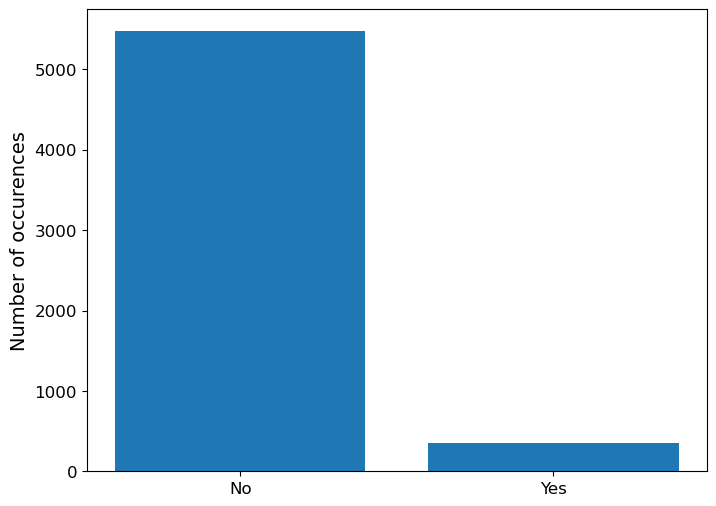

In [34]:
figure(figsize = (8, 6))
cm = countmap(purchase)
PyPlot.bar([1, 2], [cm["No"], cm["Yes"]])
xticks([1, 2], ["No", "Yes"], fontsize = 12)
yticks(fontsize = 12)
ylabel("Number of occurences", fontsize = 14)
savefig("./plots/3.3.3.png")

that's quite unbalanced

Apart from the target, all other variables are numbers; we can standardize the data:

In [35]:
y, X = unpack(caravan, ==(:Purchase), col -> true)

mstd = machine(Standardizer(), X)

Machine{Standardizer,…} trained 0 times; caches data
  model: Standardizer
  args: 
    1:	Source @598 ⏎ `Table{AbstractVector{Continuous}}`


In [36]:
fit!(mstd)

┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


Machine{Standardizer,…} trained 1 time; caches data
  model: Standardizer
  args: 
    1:	Source @598 ⏎ `Table{AbstractVector{Continuous}}`


In [37]:
Xs = MLJ.transform(mstd, X)

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.680848,-0.272557,0.406662,-1.21686,0.779338,-0.694251,0.217425,-0.0687047
2,0.992212,-0.272557,-0.859426,-1.21686,0.779338,0.302526,-0.365379,-0.0687047
3,0.992212,-0.272557,-0.859426,-1.21686,0.779338,-0.694251,-0.365379,0.914094
4,-1.18734,-0.272557,0.406662,0.0107537,-0.970896,1.2993,-0.948183,0.914094
5,1.22573,-0.272557,1.67275,-1.21686,1.47943,0.302526,-0.365379,-0.0687047
6,-0.0975619,-0.272557,-0.859426,-2.44447,-0.270802,-0.694251,0.217425,-1.0515
7,1.14789,2.19146,0.406662,-1.21686,1.12939,1.2993,-1.53099,-1.0515
8,0.680848,-0.272557,-0.859426,0.0107537,0.779338,-0.694251,1.38303,-1.0515
9,0.680848,-0.272557,-0.859426,1.23837,0.779338,-0.694251,-2.11379,1.89689


In [38]:
var(Xs[:, 1]) |> r3

1.0

**Note**: in MLJ, it is recommended to work with pipelines / networks when possible and not do "step-by-step" transformation and fitting of the data as this is more error prone. We do it here to stick to the ISL tutorial.

We split the data in the first 1000 rows for testing and the rest for training:

In [39]:
test = 1:1000
train = last(test) + 1:nrows(Xs);

Let's now fit a KNN model and check the misclassification rate

In [40]:
classif = machine(KNNClassifier(K = 3), Xs, y)
fit!(classif, rows = train)
ŷ = predict_mode(classif, rows = test)

accuracy(ŷ, y[test]) |> r3

┌ Info: Training Machine{KNNClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


0.925

that looks good but recall the problem is very unbalanced

In [41]:
mean(y[test] .!= "No") |> r3

0.059

Let's fit a logistic classifier to this problem

In [42]:
classif = machine(LogisticClassifier(), Xs, y)
fit!(classif, rows = train)
ŷ = predict_mode(classif, rows = test)

accuracy(ŷ, y[test]) |> r3

┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


0.941

### ROC and AUC

Since we have a probabilistic classifier, we can also check metrics that take scores into account such as the area under the ROC curve (AUC):

In [43]:
ŷ = MLJ.predict(classif, rows = test)

1000-element CategoricalDistributions.UnivariateFiniteArray{Multiclass{2}, String, UInt8, Float64, 1}:
 UnivariateFinite{Multiclass{2}}(No=>0.938, Yes=>0.0615)
 UnivariateFinite{Multiclass{2}}(No=>0.938, Yes=>0.0617)
 UnivariateFinite{Multiclass{2}}(No=>0.942, Yes=>0.0576)
 UnivariateFinite{Multiclass{2}}(No=>0.933, Yes=>0.0672)
 UnivariateFinite{Multiclass{2}}(No=>0.935, Yes=>0.0652)
 UnivariateFinite{Multiclass{2}}(No=>0.952, Yes=>0.0478)
 UnivariateFinite{Multiclass{2}}(No=>0.947, Yes=>0.0533)
 UnivariateFinite{Multiclass{2}}(No=>0.952, Yes=>0.0478)
 UnivariateFinite{Multiclass{2}}(No=>0.955, Yes=>0.0455)
 UnivariateFinite{Multiclass{2}}(No=>0.937, Yes=>0.0633)
 UnivariateFinite{Multiclass{2}}(No=>0.925, Yes=>0.0754)
 UnivariateFinite{Multiclass{2}}(No=>0.928, Yes=>0.0721)
 UnivariateFinite{Multiclass{2}}(No=>0.946, Yes=>0.0536)
 ⋮
 UnivariateFinite{Multiclass{2}}(No=>0.949, Yes=>0.0513)
 UnivariateFinite{Multiclass{2}}(No=>0.944, Yes=>0.056)
 UnivariateFinite{Multiclass{2}}(No=>0.9

In [44]:
auc(ŷ, y[test])

0.7284713341378627

We can also display the curve itself

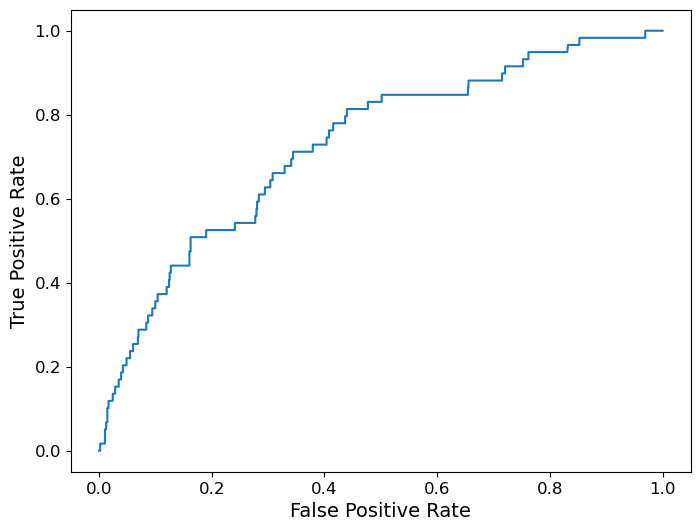

In [45]:
fprs, tprs, thresholds = roc(ŷ, y[test])

figure(figsize = (8, 6))
plot(fprs, tprs)

xlabel("False Positive Rate", fontsize = 14)
ylabel("True Positive Rate", fontsize = 14)
xticks(fontsize = 12)
yticks(fontsize = 12)
savefig("./plots/3.3.4.png")